In [13]:
#####スパース潜在特徴モデル####
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

#np.random.seed(98537)

In [14]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [15]:
####データの生成####
##データの設定
k = 10 
hh = 5000
item = 3000
Lambda = np.random.gamma(30.0, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)   #総サンプル数
k_vec = np.repeat(1, k)

In [16]:
##IDとインデックスを設定
#IDの設定
d_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
    
#インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [17]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi_topic = np.random.dirichlet(np.repeat(0.25, item), topic)
theta_topic = np.random.dirichlet(np.repeat(0.3, topic), hh)
z = np.array(rmnom(theta_topic[d_id, ], hhpt, topic, np.arange(hhpt), 0), dtype="int")

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = rmnom(phi_topic[z[d_list[i]], ], pt[i], item, np.arange(pt[i]), 0)
    
#アイテムインデックスを作成
index = np.array(range(hhpt))
item_list = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")
    item_n[j] = item_list[j].shape[0]

0
1000
2000
3000
4000


In [18]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##モデルパラメータの生成
    #事前分布の設定
    alpha1 = np.array([0.0])
    alpha2 = np.repeat(0.0, k)
    tau_u = np.array([0.5])
    tau_v = np.array([0.5])
    Cov_u = np.diag(np.repeat(0.5, k))
    pi = np.random.beta(15.0, 22.5, k)
    taut_u = tau_u.copy(); taut_v = tau_v.copy()
    Covt_u = Cov_u.copy(); pit = pi.copy()

    #モデルパラメータの生成
    Sigma = np.array(0.5)
    beta = np.array(5.5, dtype="int")
    beta_u = np.random.normal(alpha1, tau_u, hh)
    beta_v = np.random.normal(alpha1, tau_v, item)
    theta_u = np.random.multivariate_normal(alpha2, Cov_u, hh)
    Z = np.zeros((item, k), dtype="int")
    for j in range(k):
        Z[:, j] = np.random.binomial(1, pi[j], item)
    Sigmat = Sigma.copy(); betat = beta.copy()
    betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy()
    
    ##正規分布から応答変数を生成
    #モデルの期待値
    uv = np.dot(theta_u[d_id, ] * Z[item_id, ], k_vec)
    mu = beta + beta_u[d_id] + beta_v[item_id] + uv

    #データを生成
    U = np.random.normal(mu, Sigma, hhpt)

    #収束条件
    if (np.mean(U) < 6.0) & (np.mean(U) > 5.0) & (np.std(U) > 1.75) & (np.std(U) < 2.25):
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


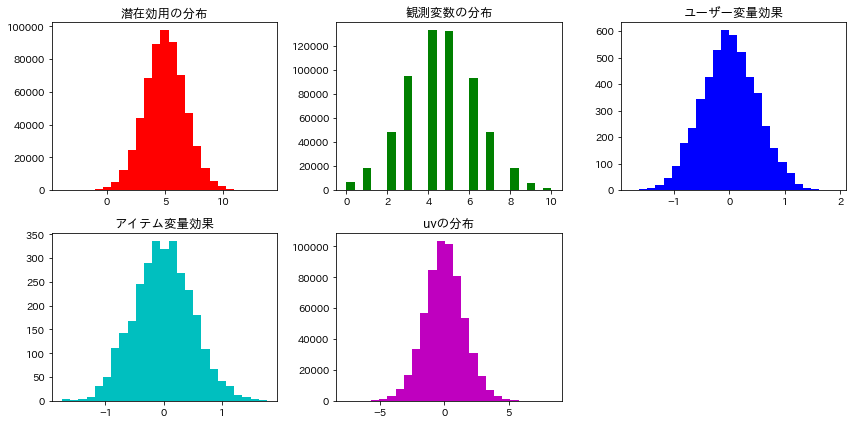

In [19]:
#応答変数の変換
y = np.array(U, dtype="int")
y[U > 10] = 10; y[U < 0] = 0

#生成したデータを可視化
dt = [U, y, beta_u, beta_v, uv]
fig_range = np.append(np.array([np.min(U), 0, np.min(beta_u), np.min(beta_v), np.min(uv)]), 
                      np.array([np.max(U), 10, np.max(beta_u), np.max(beta_v), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布", "観測変数の分布", "ユーザー変量効果", "アイテム変量効果", "uvの分布"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [20]:
####マルコフ連鎖モンテカルロ法でInfinite Latent Factor modelを推定####
##アルゴリズムの設定
k = 10
max_k = 15
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [21]:
##事前分布の設定
#IBPの集中度パラメータ
er_prob = 0.001
alpha = 1.0

#階層モデルのパラメータの事前分布
alpha1 = np.array([0.0])
alpha2 = np.repeat(0.0, k)
nu = 1.0
V = 0.1 

#モデルパラメータの事前分布
tau = 100
s0 = 1.0
v0 = 1.0

In [22]:
##パラメータの初期値
#階層モデルの初期値
tau_u = np.array([0.25])
tau_v = np.array([0.25])
Cov_u = np.diag(np.repeat(0.2, k))
inv_Cov_u = np.linalg.inv(Cov_u)
pi = np.repeat(0.25, k)

#モデルパラメータの初期値
beta = np.mean(y)
beta_u = np.random.normal(alpha1, tau_u, hh)
beta_v = np.random.normal(alpha1, tau_v, item)
theta_u = np.random.multivariate_normal(alpha2, Cov_u, hh)
Zi = np.zeros((item, k), dtype="int")
for j in range(k):
    Zi[:, j] = np.random.binomial(1, pi[j], item)
    
#モデルの期待値
beta_user = beta_u[d_id]; beta_item = beta_v[item_id]
theta_user = theta_u[d_id, ]; Zi_item = Zi[item_id, ]
uv = np.dot(theta_user * Zi_item, np.repeat(1, k))
mu = beta + beta_user + beta_item + uv

In [23]:
##対数尤度と平均二乗誤差の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y, np.mean(y), np.std(y)))
RMSEst = np.sqrt(np.sum(np.power(y - np.mean(y), 2)) / hhpt)
print([LLst, RMSEst])

#真値での対数尤度
uv0 = np.sum(thetat_u[d_id, ] * Z[item_id, ], axis=1)
mu0 = betat + betat_u[d_id] * betat_v[item_id] + uv0
Sigma0 = np.std(y - mu0)
LLbest = np.sum(scipy.stats.norm.logpdf(y, mu0, Sigma0))
RMSEbest = np.sqrt(np.sum(np.power(y - mu0, 2)) / hhpt)
print([LLbest, RMSEbest])

[-1195709.6301348987, 1.7633362427083599]
[-904600.8840764875, 1.069219665981691]


In [24]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##期待値パラメータをサンプリング
    #モデル誤差を定義
    uv = np.dot(theta_user * Zi_item, np.repeat(1, k))
    er_y = y - beta_user - beta_item - uv

    #正規分布から事後分布をサンプリング
    weights = tau / (Sigma/hhpt + tau)
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, np.sqrt(weights*Sigma/hhpt), 1)


    ##ユーザー変量効果をサンプリング
    #モデル誤差を定義
    er_y = y - beta - beta_item - uv

    #ユーザーごとに事後分布をサンプリング
    for i in range(hh):
        weights = tau_u / (Sigma/pt[i] + tau_u)
        mu_par = weights * np.mean(er_y[d_list[i]])
        beta_u[i] = np.random.normal(mu_par, np.sqrt(weights*tau_u/pt[i]))
    beta_user = beta_u[d_id]


    ##アイテム変量効果をサンプリング
    #モデル誤差を定義
    er_y = y - beta - beta_user - uv

    #アイテムごとに事後分布をサンプリング
    for j in range(item):
        weights = tau_v / (Sigma/item_n[j] + tau_v)
        mu_par = weights * np.mean(er_y[item_list[j]])
        beta_v[j] = np.random.normal(mu_par, np.sqrt(weights*tau_v/item_n[j]))
    beta_item = beta_v[item_id]


    ##アイテム潜在特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y = y - beta - beta_user - beta_item
    
    for i in range(k):

        #新しい潜在特徴ベクトルを定義
        index_delete = np.delete(np.arange(k), i)
        new_Zi0 = np.zeros((item, k), dtype="int")
        new_Zi1 = np.zeros((item, k), dtype="int")
        new_Zi0[:, index_delete] = Zi[:, index_delete]
        new_Zi1[:, index_delete] = Zi[:, index_delete]
        new_Zi1[:, i] = 1

        #尤度関数と事後分布を定義
        Prior = (np.sum(Zi[:, i]) - Zi[:, i]) / item
        uv0 = np.dot(theta_user * new_Zi1[item_id, ], np.repeat(1, k))
        uv1 = np.dot(theta_user * new_Zi0[item_id, ], np.repeat(1, k))
        mu0 = beta + beta_user + beta_item + uv0
        mu1 = beta + beta_user + beta_item + uv1
        Lho0 = scipy.stats.norm.logpdf(y, mu0, Sigma) 
        Lho1 = scipy.stats.norm.logpdf(y, mu1, Sigma) 
        Lho = np.zeros((item, 2))
        for j in range(item):
            Lho[j, 0] = np.sum(Lho0[item_list[j], ])
            Lho[j, 1] = np.sum(Lho1[item_list[j], ])
        Posterior = np.exp(Lho - np.max(Lho, axis=1)[:, np.newaxis]) * np.hstack(((1-Prior)[:, np.newaxis], Prior[:, np.newaxis]))

        #ベルヌーイ分布から特徴ベクトルをサンプリング
        Prob = Posterior[:, 1] / np.sum(Posterior, axis=1)
        Zi[:, i] = np.random.binomial(1, Prob, item)

    #パラメータを更新
    Zi_item = Zi[item_id, ]


    ##ユーザー特徴ベクトルをサンプリング
    #ユーザーごとの事後分布のパラメータ
    for i in range(hh):
        index = d_list[i]
        x = Zi_item[index, ]; u = er_y[index]
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_u
        inv_xxv = np.linalg.inv(xxv)
        theta_mu = np.dot(inv_xxv, xy + np.dot(alpha2, inv_Cov_u))

        #正規分布から特徴ベクトルをサンプリング
        theta_u[i, ] = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1)

    #パラメータを更新
    theta_user = theta_u[d_id, ]


    ##モデルの標準偏差をサンプリング
    #モデル誤差を設定
    uv = np.dot(theta_user * Zi_item, np.repeat(1, k))
    er = y - beta - beta_user - beta_item - uv

    #逆ガンマ分布のパラメータ
    s1 = np.sum(np.power(er - np.mean(er), 2)) + s0
    v1 = hhpt + v0

    #逆ガンマ分布から標準偏差をサンプリング
    Sigma = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)

    if rp%disp==0:
        #対数尤度を更新
        uv = np.sum(theta_u[d_id, ] * Zi[item_id, ], axis=1)
        mu = beta + beta_u[d_id] * beta_v[item_id] + uv
        LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))
        RMSE = np.sqrt(np.sum(np.power(y - mu, 2)) / hhpt)

        #サンプリング結果の表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 3))
        print(np.round([RMSE, RMSEst, RMSEbest], 3))

0
[-1382494.693 -1195709.63   -904600.884]
[1.85  1.763 1.069]
10
[-1318621.912 -1195709.63   -904600.884]
[1.44  1.763 1.069]
20
[-1253044.417 -1195709.63   -904600.884]
[1.346 1.763 1.069]
30
[-1233449.544 -1195709.63   -904600.884]
[1.312 1.763 1.069]
40
[-1221759.331 -1195709.63   -904600.884]
[1.308 1.763 1.069]
50
[-1208222.028 -1195709.63   -904600.884]
[1.304 1.763 1.069]
60
[-1204106.862 -1195709.63   -904600.884]
[1.302 1.763 1.069]
70
[-1206823.475 -1195709.63   -904600.884]
[1.3   1.763 1.069]
80
[-1213201.23  -1195709.63   -904600.884]
[1.305 1.763 1.069]
90
[-1213967.439 -1195709.63   -904600.884]
[1.306 1.763 1.069]
100
[-1214111.779 -1195709.63   -904600.884]
[1.307 1.763 1.069]
110
[-1216294.185 -1195709.63   -904600.884]
[1.31  1.763 1.069]
120
[-1214358.185 -1195709.63   -904600.884]
[1.307 1.763 1.069]
130
[-1209327.17  -1195709.63   -904600.884]
[1.303 1.763 1.069]
140
[-1213836.7   -1195709.63   -904600.884]
[1.305 1.763 1.069]
150
[-1209912.208 -1195709.63   -904

1260
[-1217509.482 -1195709.63   -904600.884]
[1.308 1.763 1.069]
1270
[-1214324.971 -1195709.63   -904600.884]
[1.306 1.763 1.069]
1280
[-1218246.107 -1195709.63   -904600.884]
[1.309 1.763 1.069]
1290
[-1223838.635 -1195709.63   -904600.884]
[1.314 1.763 1.069]
1300
[-1220807.834 -1195709.63   -904600.884]
[1.312 1.763 1.069]
1310
[-1218330.572 -1195709.63   -904600.884]
[1.31  1.763 1.069]
1320
[-1221109.918 -1195709.63   -904600.884]
[1.311 1.763 1.069]
1330
[-1214942.747 -1195709.63   -904600.884]
[1.306 1.763 1.069]
1340
[-1209901.867 -1195709.63   -904600.884]
[1.303 1.763 1.069]
1350
[-1212935.262 -1195709.63   -904600.884]
[1.303 1.763 1.069]
1360
[-1209683.995 -1195709.63   -904600.884]
[1.303 1.763 1.069]
1370
[-1213217.527 -1195709.63   -904600.884]
[1.305 1.763 1.069]
1380
[-1219755.657 -1195709.63   -904600.884]
[1.311 1.763 1.069]
1390
[-1223898.916 -1195709.63   -904600.884]
[1.311 1.763 1.069]
1400
[-1224228.818 -1195709.63   -904600.884]
[1.315 1.763 1.069]
1410
[-122